In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eth.csv')
print(df)

      Unnamed: 0 formatted_date         high          low         open  \
0              0     2019-01-01   141.397507   132.650711   141.519516   
1              1     2019-01-02   156.929138   140.650955   155.196045   
2              2     2019-01-03   155.863052   147.198364   148.912888   
3              3     2019-01-04   156.878983   147.907104   154.337418   
4              4     2019-01-05   160.824890   154.337418   155.804230   
...          ...            ...          ...          ...          ...   
1515        1515     2023-02-24  1661.091309  1583.147827  1608.658325   
1516        1516     2023-02-25  1608.865112  1567.631714  1594.761108   
1517        1517     2023-02-26  1645.273438  1590.393066  1640.763672   
1518        1518     2023-02-27  1662.575684  1615.387939  1634.502441   
1519        1519     2023-02-28  1644.435791  1602.428101  1606.040405   

            close      volume     adjclose  
0      140.819412  2258709868   140.819412  
1      155.047684  33

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,119.715439,116.157440,117.110756,117.157852,2421720343,117.157852,3.557999,121.640524,127.196642,135.496240,2.635404,15.088666
21,21,2019-01-22,119.664345,114.676682,118.713814,118.747551,2552507405,118.747551,4.987663,121.171215,124.938636,134.445199,2.838598,15.463410
22,22,2019-01-23,119.422798,116.376648,117.462784,117.452606,2556952198,117.452606,3.046150,120.300577,122.556456,132.654957,2.921848,15.131627
23,23,2019-01-24,118.032104,116.006798,117.594955,117.362885,2520843420,117.362885,2.025307,119.389287,121.752007,131.141999,2.651955,14.989176
24,24,2019-01-25,117.802994,115.830154,116.373528,116.378342,2606881898,116.378342,1.972839,118.727584,120.954151,129.322780,2.755917,14.304793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,1661.091309,1583.147827,1608.658325,1608.373169,8909129423,1608.373169,77.943481,1662.377982,1626.017447,1622.058291,32.361529,64.912140
1516,1516,2023-02-25,1608.865112,1567.631714,1594.761108,1594.914917,5657686235,1594.914917,41.233398,1648.534476,1629.945173,1618.622849,37.917844,64.317786
1517,1517,2023-02-26,1645.273438,1590.393066,1640.763672,1640.817139,5727967432,1640.817139,54.880371,1642.731759,1638.929705,1619.059576,35.042625,64.441653
1518,1518,2023-02-27,1662.575684,1615.387939,1634.502441,1634.326416,7239824677,1634.326416,47.187744,1632.967651,1648.012599,1619.920497,23.014437,64.522916


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.3)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

450
(1043, 7, 9) (1043, 1) (450, 7, 9) (450, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 20s 15ms/step - loss: 0.0118
Epoch 2/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0048
Epoch 3/120
40/40 [==============================] - 1s 16ms/step - loss: 0.0033
Epoch 4/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 5/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0031
Epoch 6/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 7/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 8/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 9/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 10/120
40/40 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 11/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0033
Epoch 12/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

33/33 [==============================] - 3s 4ms/step
      predict_price  y_train_price  error_price
0         91.316612     106.589973   -15.273361
1         85.439613     105.598213   -20.158600
2         80.380539     108.907539   -28.527000
3         79.763313     107.061012   -27.297699
4         80.611816     107.609787   -26.997971
...             ...            ...          ...
1038    4493.226074    4586.990234   -93.764160
1039    4499.509766    4511.302246   -11.792480
1040    4504.762207    4220.706055   284.056152
1041    4460.881836    4119.587402   341.294434
1042    4313.583496    4198.322754   115.260742

[1043 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

15/15 [==============================] - 0s 7ms/step
[[0.8957052 ]
 [0.89979935]
 [0.9061192 ]
 [0.91500556]
 [0.9031085 ]
 [0.89471483]
 [0.8911811 ]
 [0.8937576 ]
 [0.8697574 ]
 [0.8527647 ]
 [0.85324955]
 [0.85612476]
 [0.84808767]
 [0.84579647]
 [0.8496666 ]
 [0.85221696]
 [0.8620502 ]
 [0.86561275]
 [0.87811327]
 [0.88533103]
 [0.8941814 ]
 [0.89915264]
 [0.9018371 ]
 [0.887383  ]
 [0.86035097]
 [0.8488126 ]
 [0.8393825 ]
 [0.83611107]
 [0.8371482 ]
 [0.8327435 ]
 [0.83997524]
 [0.82401586]
 [0.7995508 ]
 [0.76491344]
 [0.7258822 ]
 [0.710472  ]
 [0.6855743 ]
 [0.6847093 ]
 [0.6955669 ]
 [0.6901432 ]
 [0.6955148 ]
 [0.70266604]
 [0.71371365]
 [0.70833933]
 [0.6993755 ]
 [0.6906682 ]
 [0.6822393 ]
 [0.6152888 ]
 [0.55440164]
 [0.546693  ]
 [0.5256084 ]
 [0.5216072 ]
 [0.529086  ]
 [0.5088091 ]
 [0.52126   ]
 [0.53196776]
 [0.54106426]
 [0.5543151 ]
 [0.5747881 ]
 [0.5739459 ]
 [0.57229435]
 [0.605023  ]
 [0.62377644]
 [0.6420733 ]
 [0.66282785]
 [0.6737733 ]
 [0.69529307]
 [0.69126

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[4283.9814 ]
 [4303.255  ]
 [4333.0063 ]
 [4374.84   ]
 [4318.833  ]
 [4279.3193 ]
 [4262.684  ]
 [4274.813  ]
 [4161.83   ]
 [4081.8352 ]
 [4084.1174 ]
 [4097.653  ]
 [4059.8174 ]
 [4049.0312 ]
 [4067.2505 ]
 [4079.2563 ]
 [4125.5474 ]
 [4142.3184 ]
 [4201.1655 ]
 [4235.144  ]
 [4276.808  ]
 [4300.2104 ]
 [4312.8477 ]
 [4244.8037 ]
 [4117.5483 ]
 [4063.23   ]
 [4018.8372 ]
 [4003.4365 ]
 [4008.3188 ]
 [3987.5835 ]
 [4021.6274 ]
 [3946.4973 ]
 [3831.3257 ]
 [3668.267  ]
 [3484.5237 ]
 [3411.979  ]
 [3294.7708 ]
 [3290.6987 ]
 [3341.8118 ]
 [3316.2793 ]
 [3341.5664 ]
 [3375.2317 ]
 [3427.2393 ]
 [3401.939  ]
 [3359.7412 ]
 [3318.751  ]
 [3279.0708 ]
 [2963.8953 ]
 [2677.2632 ]
 [2640.974  ]
 [2541.7166 ]
 [2522.8804 ]
 [2558.0876 ]
 [2462.632  ]
 [2521.2458 ]
 [2571.6536 ]
 [2614.4763 ]
 [2676.8557 ]
 [2773.2344 ]
 [2769.2695 ]
 [2761.4949 ]
 [2915.568  ]
 [3003.8513 ]
 [3089.9854 ]
 [3187.6897 ]
 [3239.2163 ]
 [3340.5227 ]
 [3321.5435 ]
 [3231.6665 ]
 [3157.808  ]
 [3096.6296 ]
 [3079

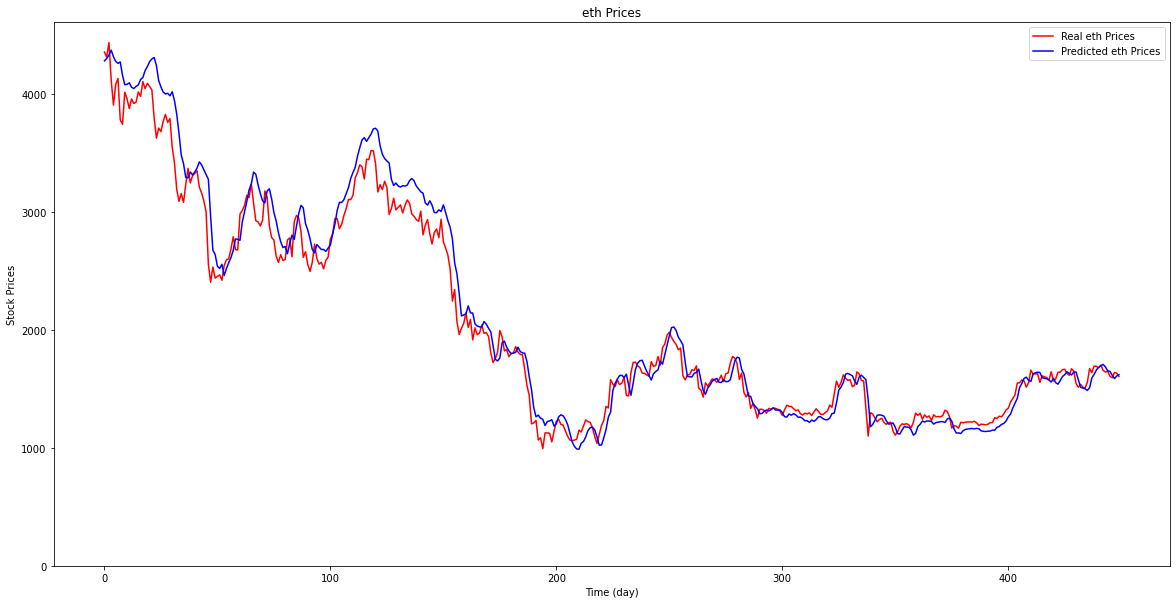

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real eth Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted eth Prices")
plt.title(f"eth Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 117.54
MAPE: 5.57%
MSE: 27329.23
RMSE: 165.32
R2: 0.96


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))